# Assignment 7 - Sound Localisation

By - Nishanth Senthil Kumar (EE23B049)

## Instructions on how to run the code

- Please ensure that numpy, matplotlib are present in the machine that you are running this notebook on, if not, please install them using pip install. 
- Please ensure that the input files "rx2.txt" and "rx3.txt" are present in the same directory as this code.
- Ensure the cells are run sequentially, and ensure the function definition cells are run before running the other cells. In case of some error or unexpected behavior, start running the cells from the beginning again.


- Parameters given by sir for the first part

In [56]:
import numpy as np
# Main system parameters: number of mics, number of samples in time
Nmics = 8
Nsamp = 50
# Source: x,y coordinates: x: 0+, y: [-Y, +Y] where Y determined by pitch and Nmics
src = (0, 0)
# Spacing between microphones
pitch = 0.1
# proxy for sampling rate
dist_per_samp = 0.1
# Speed of sound in the medium
C = 2
# Time dilation factor for sinc pulse: how narrow
SincP = 5
# CODE Locations of microphones
mics = []
# Location of point obstacle
obstacle = (3, -1)

## Part 1 - Generating the sinc pulses given in the Question


In [57]:
# Source sound wave - time axis and wave
# sinc wave with narrowness determined by parameter

# Note : The code where I generate the times is later on.
t = 0 
def wsrc(t):
    return np.sinc(SincP*t)

The two plots given in the question have been generated using the given sinc function.
- I have adjusted the number of samples to be 1000, otherwise the curve wont be smooth. So to generate a smooth curve you require a good amount of sample points.
- Varying the value of SincP allows us to generate the given graphs. The greater the value of SinP, the narrower the oscillations (which occur at a higher frequency) and the faster is the decay. 
- The narrower sinc pulse (Figure 2 in the problem statement and the orange graph generated here) will provide more precision in locating an object because the sharp peak allowed us to distinguish between closely spaces objects, whereas the graph with the broader peak might not be able to pinpoint the location as well. 
- However, if we consider noise in the system, the broader pulse will be a better alternative, as it will be less affected by noise spikes, due to its more gradual decay rate. 



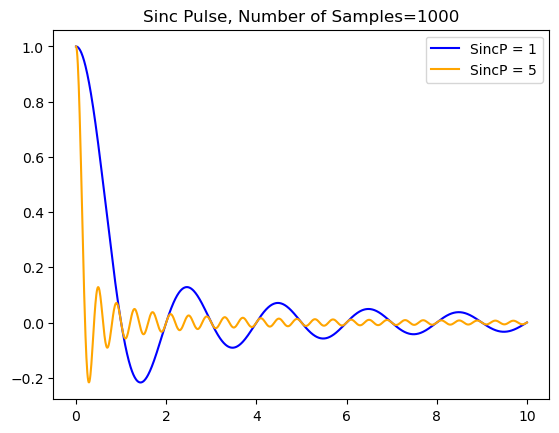

In [58]:
import matplotlib.pyplot as plt

# Setting the SincP value
SincP=1

# generating an array of the times at which we will sample the signal
time_samples=np.linspace(0,10,int(1000))

# generating the sampled values
sampled_values=[]
for i in time_samples:
    sampled_values.append(wsrc(i))
sampled_values=np.array(sampled_values)

# plotting the signal we got by sampling
plt.title("Sinc Pulses (Number of Samples=1000)")
plt.plot(time_samples,sampled_values,label="SincP = 1", color="blue")

# Setting the SincP value again
SincP=5

# generating the sampled values
sampled_values=[]
for i in time_samples:
    sampled_values.append(wsrc(i))
sampled_values=np.array(sampled_values)

# plotting the signal we got by sampling
plt.title("Sinc Pulse, Number of Samples=1000")
plt.plot(time_samples,sampled_values,label="SincP = 5", color="orange")
plt.legend()
plt.show()

## Part 2 - Setup and Generating Mic Output

In [59]:
# defining the parameters given by sir in the problem statement
Nmics = 64
Nsamp = 200
C = 2
obstacle= (3, -1)
src = (0, 0)
pitch = 0.1
dist_per_samp = 0.1

In [60]:
def generating_mic_locations(src,Nmics,pitch):
    '''
    Description : Generates the locations of the mics symmatric about the orgin on the y axis
    Input: src -> Location of the source(tuple)
           Nmics -> Number of Microphones
           pitch -> Distance between 2 mics on the Y axis
    Output : A list of tuples with the mic coordinates
    '''

    mics=[]
    # The x coordinate of all the mics is the x coordinate of the source, and it is symmetic about origin in the y axis
    x_coordinate=src[0]
    y_above=src[1]
    y_below=src[0]

    # The distance between 2 consecutive mics is the pitch
    for i in range(Nmics//2):
        if(i==0):
            y_above=y_above+pitch/2
            y_below=y_below-pitch/2
            mics.append((x_coordinate,y_above))
            mics.append((x_coordinate,y_below))
        else:
            y_above=y_above+pitch
            y_below=y_below-pitch
            mics.append((x_coordinate,y_above))
            mics.append((x_coordinate,y_below))

    # adding an extra mic at origin if the number of mics is odd in number
    if(Nmics%2==1):
        mics.append((0,0))

    return mics

In [61]:
# Distance from src to a mic after reflecting through pt
# I am assuming mic, pt and src are all tuples.
# Finding the distance from the source, to the point, and from the point to the mic of question. 
def dist(src, pt, mic):
    d1 = ((src[0]-pt[0])**2+(src[1]-pt[1])**2)**0.5 # CODE distance from src to pt
    d2 = ((pt[0]-mic[0])**2+(pt[1]-mic[1])**2)**0.5 # CODE distance from pt to mic
    return d1 + d2

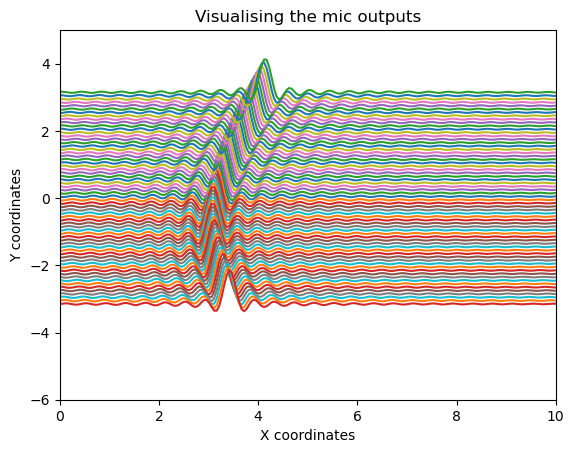

In [62]:
#converting the distance proxy for sampling time into time
sampling_time=dist_per_samp/C
mics=generating_mic_locations(src,Nmics,pitch)

#finding the delays of the mics for the obstacle
for mic_coords in mics:
    mic_distance=dist(src,obstacle,mic_coords)
    mic_time=mic_distance/C

    #generating the sampling times
    times=np.linspace(0,sampling_time*Nsamp,Nsamp)

    #generating the signal outputs from the times at which we sample
    outputs2=[]
    for time in times:
        outputs2.append(mic_coords[1]+wsrc(time-mic_time))

    outputs2=np.array(outputs2)

    #plotting the response from each mic
    plt.plot(times,outputs2)

plt.title("Visualising the mic outputs")
plt.xlabel("X coordinates")
plt.ylabel("Y coordinates")
plt.xlim(0,Nsamp*dist_per_samp//2)
plt.ylim(-(Nmics*pitch)//2-2,(Nmics*pitch)//2+2)
plt.show()

## Part 3 - Implementing DAS algorithm
Answer to question 2 : It is reasonable to plot till Nsamp//2, since the source wave has to go to the point and come back.So this duration is optimal to get the information required to plot the heatmap.

Remaining Answers are in the report. 

In [63]:
def constructing_image(mics,Nsamp,filename):
    '''
    Description : Reconstructs the image based on the intensities observed by the mics at some time stamps
    Input : mics -> List of the locations of the microphones
            Nsamp -> Number of samples taken by the microphones
            filename -> The textfile from which the input matrices recordings are given
    Output : The function does not explicitly return any value, it plots the reconstructed graph. 
    
    '''

    #loading the data from the file input.
    mic_data=np.loadtxt(filename)
    print("Image forming... Please wait around 5 - 10 seconds")
   
    #got this snippet of code from stack overflow becoz I wanted a for loop where I can have decimal ranges
    #Link : https://stackoverflow.com/questions/39714647/can-you-use-float-numbers-in-this-for-loop
    def decimal_range(start, stop, increment):
        while start < stop: # and not math.isclose(start, stop): Py>3.5
            yield start
            start += increment
    
    #generating the 2D grid that we need. 
    grid_coordinates=[]
    for x in decimal_range(0,Nsamp*dist_per_samp//2,dist_per_samp*2):
        for y in decimal_range(-(Nmics*pitch)//2,(Nmics*pitch)//2,pitch*2):
            grid_coordinates.append((x,y))

    #sorting the mics array as when we generated them, they are not ordered from top to bottom
    mics=sorted(mics)

    #generating the delays for each coordinate in the grid for each microphone
    delays_per_coordinate=dict()
    mic_index=0

    for mic in mics:
        for coordinates in grid_coordinates:
            delays_per_coordinate[mic_index,coordinates]=dist(src,coordinates,mic)/C
        mic_index+=1

    #this is a dictionary that will store the intensites of every point on the grid
    reconstructed_intensities=dict()
    for coordinates in grid_coordinates:
        reconstructed_intensities[coordinates]=0

    #generating the timestamps at which the mics will sample data
    delays=[]
    delay=0
    for i in range(Nsamp):
        delays.append(delay)
        delay+=dist_per_samp/C
    delays=np.array(delays)

    #adding the intensity of the closest input sample point for each coordinate in the grid
    for items in (delays_per_coordinate.keys()):
        for i in range(0,(Nsamp)):
            if(abs(delays_per_coordinate[items]-delays[i])<=dist_per_samp/(2*C)):
                reconstructed_intensities[items[1]]+=mic_data[items[0]][i]

    #processing the data so that it can be plotted
    x_coords = sorted({x for x, y in grid_coordinates})
    y_coords = sorted({y for x, y in grid_coordinates})
    intensity_grid = np.zeros((len(y_coords), len(x_coords)))

    for (x, y), intensity in reconstructed_intensities.items():
        x_idx = x_coords.index(x)
        y_idx = y_coords.index(y)
        intensity_grid[y_idx, x_idx] = intensity

    X, Y = np.meshgrid(x_coords, y_coords)

    #plotting the intensities dictionary in the form of a heatmap
    plt.figure(figsize=(12, 6))
    contour = plt.contourf(X, Y, intensity_grid, levels=100, cmap='viridis')
    plt.colorbar(contour, label='Intensity')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Reconstructed Intensities Heatmap')
    plt.show()


These are the outputs for the given text files.

Image forming... Please wait around 5 - 10 seconds


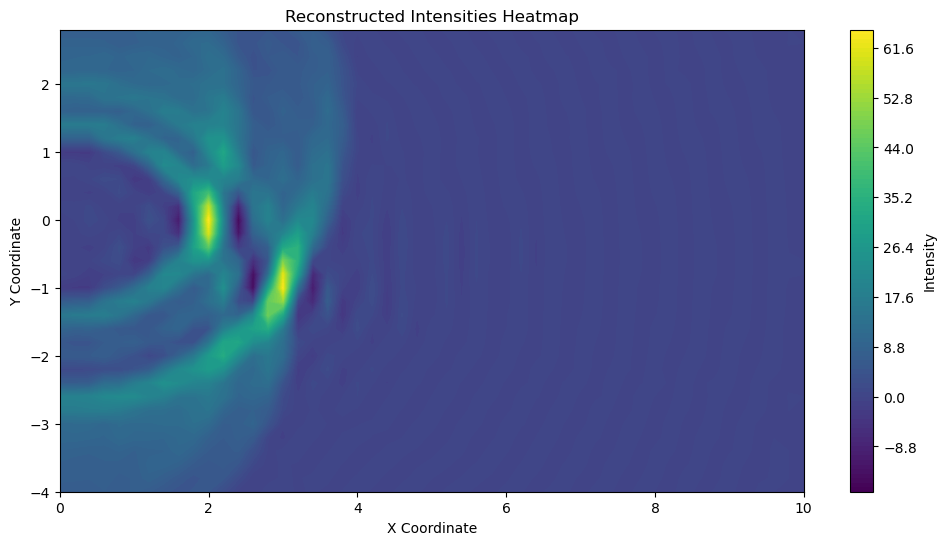

In [64]:
#ensure that the cell with generating_mic_locations is run before running this
mics=generating_mic_locations(src,Nmics,pitch)
constructing_image(mics,Nsamp,"rx2.txt")

Image forming... Please wait around 5 - 10 seconds


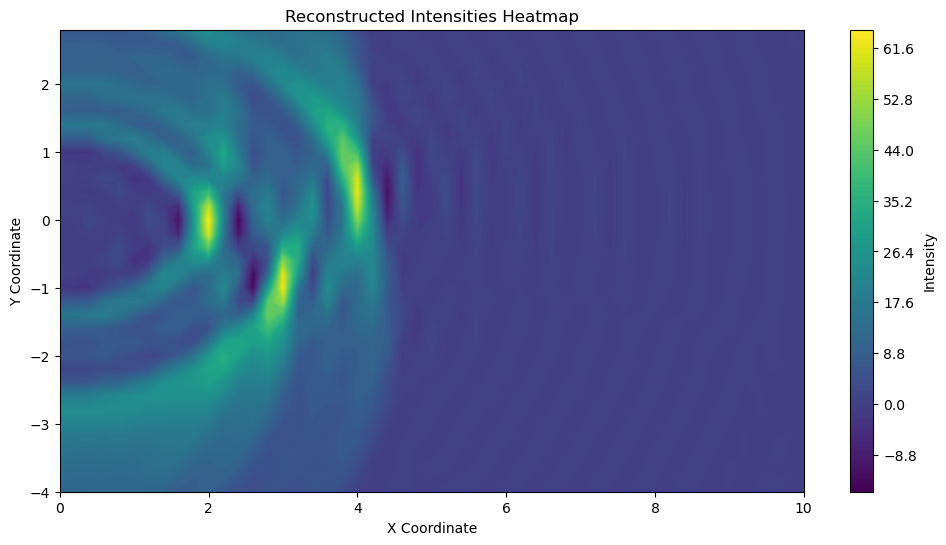

In [65]:
#ensure that the cel with generating_mic_locations is run before running this
mics=generating_mic_locations(src,Nmics,pitch)
constructing_image(mics,Nsamp,"rx3.txt")

These are the outputs for the last question in the problem statement

Image forming... Please wait around 5 - 10 seconds


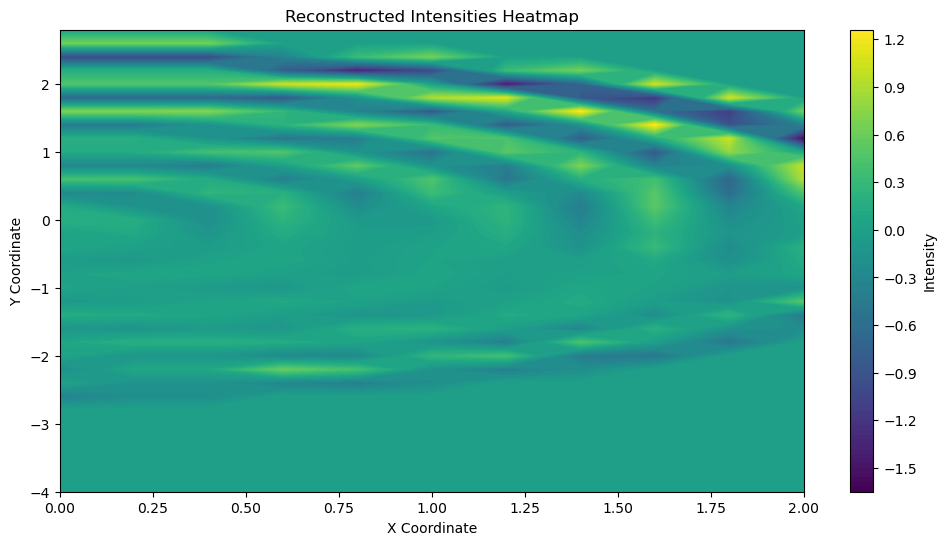

In [66]:
#for 8 mics and 50 samples
mics=generating_mic_locations(src,8,pitch)
constructing_image(mics,50,"rx2.txt")

Image forming... Please wait around 5 - 10 seconds


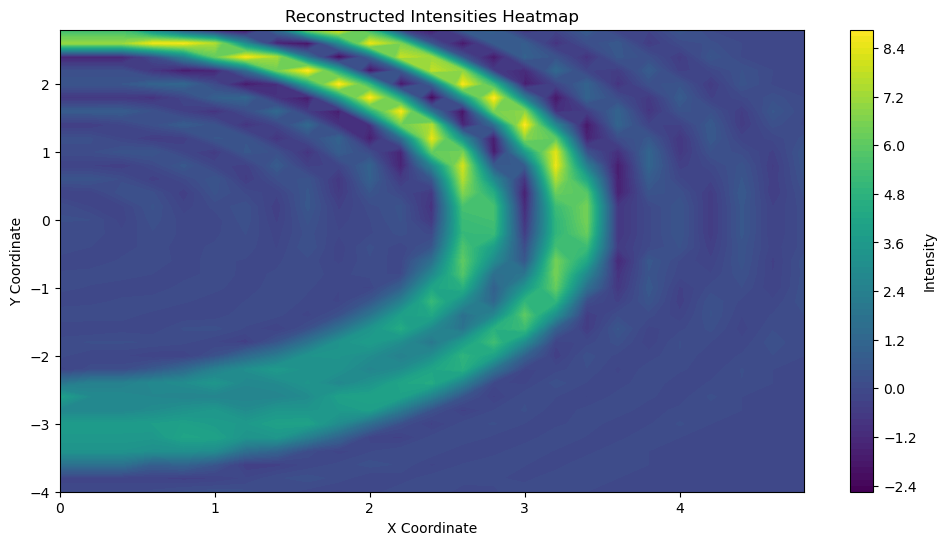

In [67]:
#for 8 mics and 100 samples
mics=generating_mic_locations(src,8,pitch)
constructing_image(mics,100,"rx2.txt")

Image forming... Please wait around 5 - 10 seconds


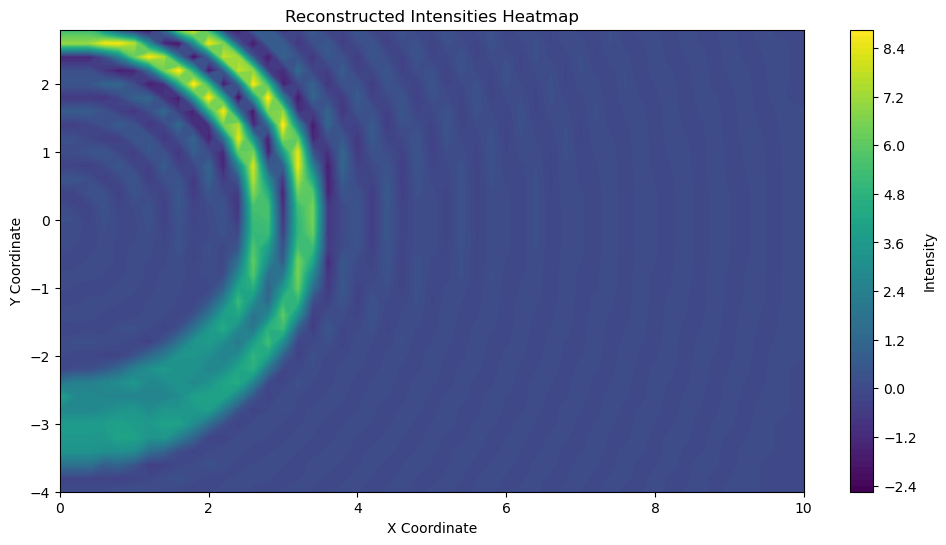

In [68]:
#for 8 mics and 200 samples
mics=generating_mic_locations(src,8,pitch)
constructing_image(mics,200,"rx2.txt")

Image forming... Please wait around 5 - 10 seconds


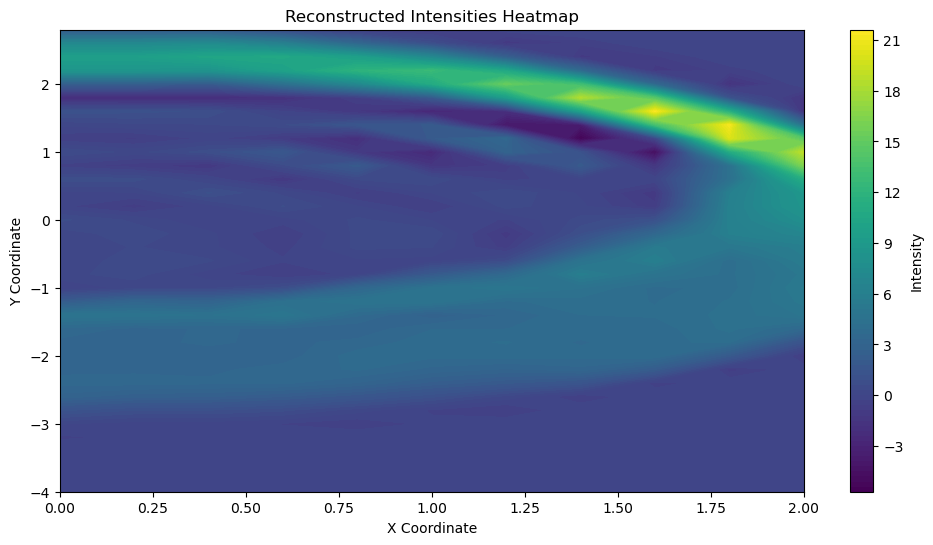

In [69]:
#for 32 mics and 50 samples
mics=generating_mic_locations(src,32,pitch)
constructing_image(mics,50,"rx2.txt")

Image forming... Please wait around 5 - 10 seconds


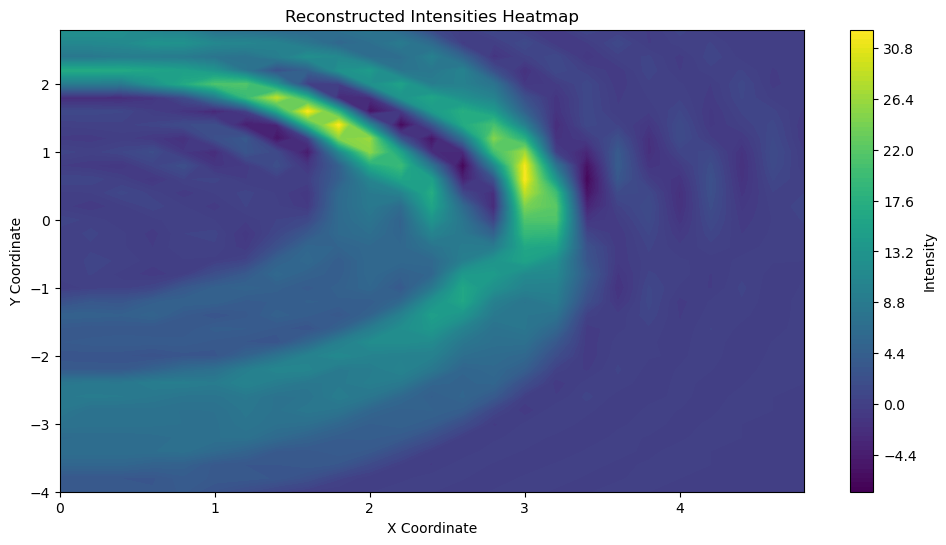

In [70]:
#for 32 mics and 100 samples
mics=generating_mic_locations(src,32,pitch)
constructing_image(mics,100,"rx2.txt")

Image forming... Please wait around 5 - 10 seconds


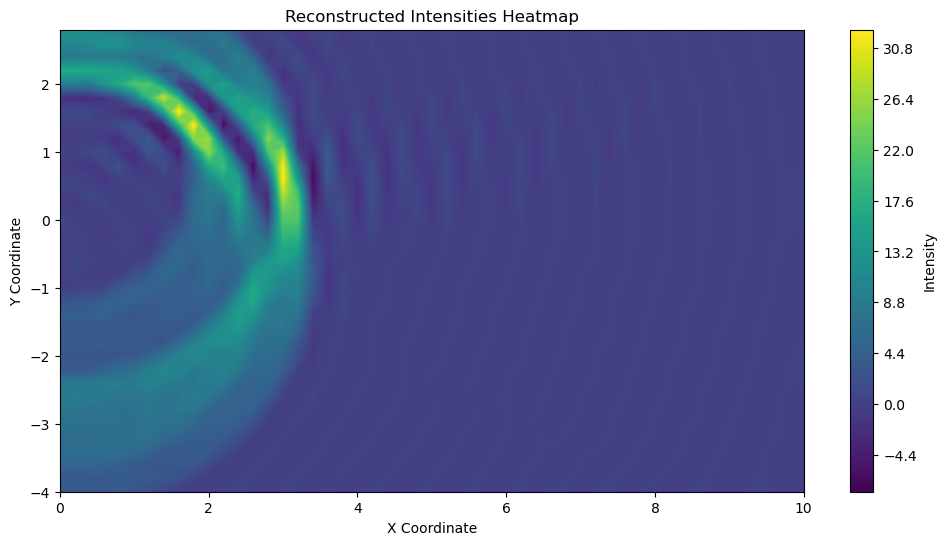

In [71]:
#for 32 mics and 200 samples
mics=generating_mic_locations(src,32,pitch)
constructing_image(mics,200,"rx2.txt")

Image forming... Please wait around 5 - 10 seconds


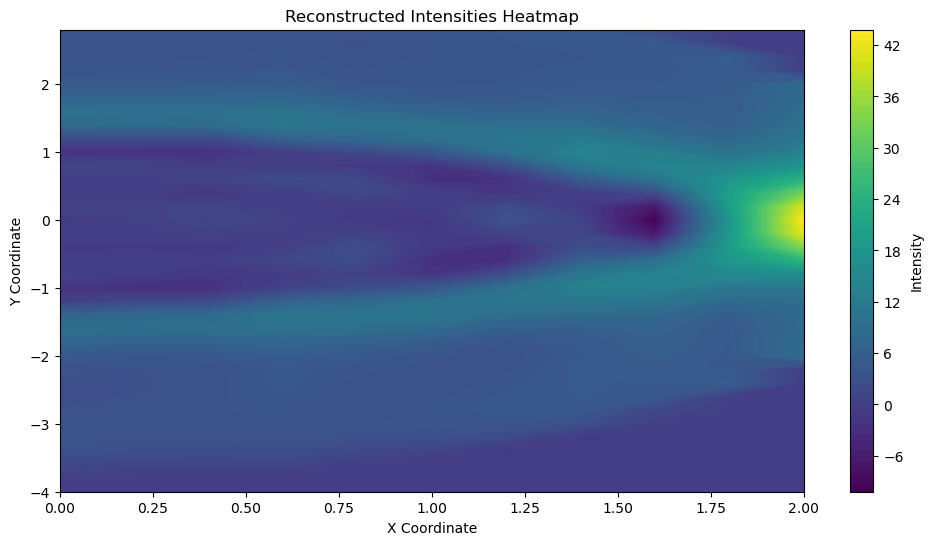

In [72]:
#for 64 mics and 50 samples
mics=generating_mic_locations(src,64,pitch)
constructing_image(mics,50,"rx2.txt")

Image forming... Please wait around 5 - 10 seconds


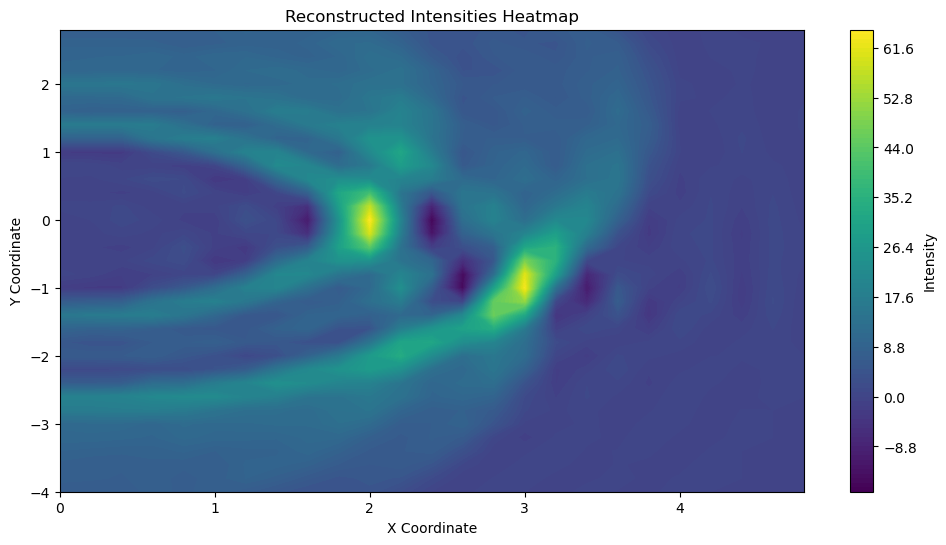

In [73]:
#for 64 mics and 100 samples
mics=generating_mic_locations(src,64,pitch)
constructing_image(mics,100,"rx2.txt")

Image forming... Please wait around 5 - 10 seconds


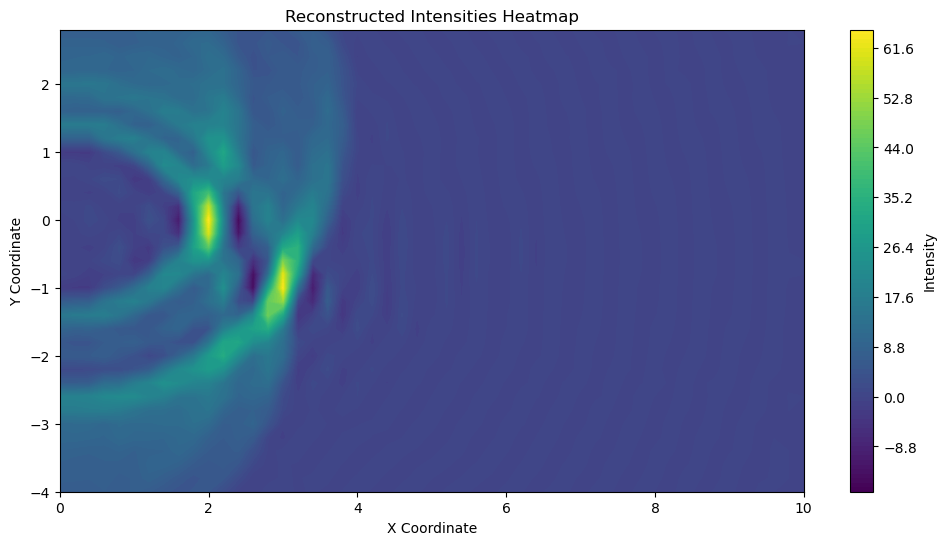

In [74]:
#for 64 mics and 200 samples
mics=generating_mic_locations(src,64,pitch)
constructing_image(mics,200,"rx2.txt")